# Assignment 4

# MAS DSE200

## Instructions

* The answers to the questions should be submitted on github. 
* You don’t need to explain your approach (unless specified) so please be concise in your submission. 
* To obtain full marks for a question, both the answer and the code should be correct. 
* Completely wrong (or missing) code with correct answer will result in zero marks. 
* Please code the solution in the space provided.<br><br>
* Code output format is specified like this when applicable
<i style='color:blue'>
* Output Required:
    * datatype or format -- description
    * datatype or format -- description
    *  ...
</i>

### Imports

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import urllib3
import json
from math import pi

urllib3.disable_warnings()
%matplotlib inline

Use the given code snippet to access the data files

### Education Data

Download county-level public school finances data ([Individual Unit Tables](https://www.census.gov/data/tables/2005/econ/school-finances/secondary-education-finance.html)) from [here](https://www.census.gov/programs-surveys/school-finances/data/tables.html) for year 2016. 

#### Fields
* CONUM: FIPS code 
    * formatted as state FIPS + county FIPS, these are separate columns in the SAIPE data. This notebook comes with code that deals with this.
* TOTALREV: Total Revenue for primary and secondary schools
* TFEDREV: Total federal revenue
* TSTREV: Total state revenue
* TLOCREV: Total local revenue
* TOTALEXP: Total expenditure

[Full Documentation](https://www2.census.gov/programs-surveys/school-finances/tables/2015/secondary-education-finance/school15doc.pdf)

### SAIPE Data
https://www.census.gov/programs-surveys/saipe/data/datasets.All.html


The data fields are described here (in File Layout):https://www.census.gov/data/datasets/2015/demo/saipe/2015-state-and-county.html 

#### Fields
* State FIPS Code
* County FIPS Code
* Poverty Estimate, All Ages
* Poverty Percent, All Ages

In [2]:
# ----- do not modify this cell -----

# Templates for pulling data from different years
url_templat_edu = 'https://www2.census.gov/programs-surveys/school-finances/tables/{}/secondary-education-finance/elsec{}t.xls'
url_template_saipe = 'https://www2.census.gov/programs-surveys/saipe/datasets/{}/{}-state-and-county/est{}all.xls'

# Columns we are interested for each dataset
use_cols_saipe = ['State FIPS Code', 'County FIPS Code','Name', 'Poverty Percent, All Ages']
use_cols_edu = ['NAME', 'CONUM', 'TOTALREV', 'TFEDREV', 'TSTREV', 'TLOCREV', 'TOTALEXP']

# Format our urls with 2016
year = '2016'
url_edu = url_templat_edu.format(year, year[2:])
url_saipe = url_template_saipe.format(year, year, year[2:])

# Get education finance data
print("Extracting data from:", url_edu)
edu_df = pd.read_excel(url_edu)[use_cols_edu]
edu_df['CONUM'] = edu_df['CONUM'].astype(str)
        
# Get SAIPE data
print("Extracting data from:", url_saipe)
saipe_df = pd.read_excel(url_saipe, header=3)[use_cols_saipe]
# Format the FIPS code so it matches edu_df's format. This column will be used to merge the dataframes later.
saipe_df['County FIPS Code'] = saipe_df['State FIPS Code'].map(str) + saipe_df['County FIPS Code'].map(str)

print("DataFrame for SAIPE data:", saipe_df.shape)
print("DataFrame for education finance data:", edu_df.shape)

Extracting data from: https://www2.census.gov/programs-surveys/school-finances/tables/2016/secondary-education-finance/elsec16t.xls
Extracting data from: https://www2.census.gov/programs-surveys/saipe/datasets/2016/2016-state-and-county/est16all.xls
DataFrame for SAIPE data: (3194, 4)
DataFrame for education finance data: (14325, 7)


Your task in this section is to show whether or not counties that invested more than average in education have seen a significant decrease in poverty in later years, as compared with counties which invested less than average.

It is an open-ended task. We are looking to see whether you can visualize the data and identify trends.

## Part 1: Clustering (Education Finance Data)

We will perform cluster analysis on counties using their associated educational finance figures
This uses `edu_df` defined above

### 1.1 Data 
Print the DataFrame's shape as well as it's first few entries. Make sure it has no null entries. 


<i style='color:blue'>
<ul><li>Output Required:<ul>
    <li>tuple     -- DataFrame's shape</li>
    <li>DataFrame -- The head of the `edu_df` DataFrame</li>
    <li>int       -- The number of missing values in the DataFrame</li>
</ul></li></ul>
</i>

In [3]:
num_nan_samples = len(edu_df[edu_df.isna().any(axis=1)])
edu_df = edu_df[~edu_df.isna().any(axis=1)]
print(num_nan_samples, 'dropped')
print(edu_df.shape)
edu_df.head()

0 dropped
(14325, 7)


,NAME,CONUM,TOTALREV,TFEDREV,TSTREV,TLOCREV,TOTALEXP
0,AUTAUGA COUNTY SCHOOL DISTRICT,1001,80867,7447,53842,19578,76672
1,BALDWIN COUNTY SCHOOL DISTRICT,1003,338236,23710,145180,169346,299880
2,BARBOUR COUNTY SCHOOL DISTRICT,1005,10116,2342,5434,2340,10070
3,EUFAULA CITY SCHOOL DISTRICT,1005,26182,3558,15900,6724,29843
4,BIBB COUNTY SCHOOL DISTRICT,1007,32486,3664,21846,6976,31662


### 1.2 Features - 2 points

We'll now construct a new DataFrame containing only the features we want to use for clustering.<br>
**Start by creating a copy of edu_df** using DataFrame.copy so that you have an unaltered copy of the original. <br>
Then, **drop the these columns**: `NAME`, `CONUM`.<br>
You must then **normalize the data.** <br><br>
*If methodology for normalizing is unclear, see the clustering or radial plot notebooks from day 4.<br>
If the motivation for normalizing is unclear, start a Piazza discussion*<br><br>


<i style='color:blue'>
<ul><li>Output Required:<ul>
        <li>tuple     -- DataFrame's shape</li>
        <li>DataFrame -- The head of the DataFrame</li>
</ul></li></ul>

In [4]:
X = edu_df.copy()
X = X.drop(['NAME', 'CONUM'], axis=1)
features_used = X.columns

for column in features_used:
    X[column] -= X[column].mean()    
    X[column] /= X[column].std()
    
print(X.shape)
X.head()

(14325, 5)


,TOTALREV,TFEDREV,TSTREV,TLOCREV,TOTALEXP
0,0.119653,0.165508,0.259610,-0.014237,0.100770
1,1.045707,0.899419,1.008906,1.020939,0.864655
2,-0.134920,-0.064868,-0.137507,-0.133383,-0.127162
3,-0.077112,-0.009993,-0.051649,-0.103082,-0.059493
4,-0.054430,-0.005210,-0.002870,-0.101340,-0.053268


### 1.3 KMeans Clustering

Define a model using <a href='http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html'>sklearn.cluster.kmeans</a><br>
**Pick any value for the number of clusters for now. When you finish all parts to this question, you can come back and experiment.**<br>
Print the model to see all the parameter values.<br>
Then, fit the model to your normalized data. <br>
Print the resulting cluster centers.<br><br>


<i style='color:blue'>
<ul><li>Output Required:<ul>
        <li>Initialized K-Means model; shows all parameter values</li>
        <li>list -- Cluster centers from fitted model</li>
</ul></li></ul>

In [12]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=8)
model = kmeans.fit(X)
centers = model.cluster_centers_
print("model\n", model, "\n")
print("centers\n", centers)

model
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0) 

centers
 [[ 3.45647191e-01  2.96760588e-01  3.68134610e-01  3.08346154e-01
   3.22650738e-01  6.45317133e-16]
 [ 9.85922204e+01  7.83109273e+01  8.65131112e+01  1.04504596e+02
   1.01207245e+02  1.00000000e+00]
 [ 3.69954287e+01  4.90817244e+01  5.50390849e+01  1.71757438e+01
   3.29873404e+01  3.00000000e+00]
 [ 3.74171548e+00  4.90181134e+00  3.74913363e+00  3.27803649e+00
   3.62139733e+00  2.08333333e+00]
 [ 9.26292501e+00  1.09399628e+01  8.63008407e+00  8.84672914e+00
   8.68070083e+00  4.00000000e+00]
 [ 1.39478110e+00  1.62790689e+00  1.64002027e+00  1.04817051e+00
   1.30467426e+00  2.00000000e+00]
 [-1.03409573e-01 -1.09845717e-01 -1.10585648e-01 -8.86463154e-02
  -9.79295975e-02 -9.50628465e-16]
 [ 1.88005766e+01  3.55894693e+01  1.45213258e+01  1.84290021e+01
   2.02456852e+01  4.0

### 1.4 Visualize and Analyze Cluster Centers
**a)**
Create a Pandas DataFrame containing all the cluster centers.<br>
You'll need to add a column titled 'cluster' containing the ID of the cluster. A cluster's ID is its index in the list you printed in **1.3**. Note that this process is shown in the k-means clustering notebook.<br>
Print the entire resulting DataFrame.<br>


<i style='color:blue'>
<ul><li>Output Required:<ul>
        <li>DataFrame -- Cluster centers dataframe<ul>
            <li>Columns should be: TOTALREV, TFEDREV, TSTREV, TLOCREV, TOTALEXP, cluster</li></ul>
        </li>
</ul></li></ul>

In [6]:
colnames = list(features_used)
colnames.append('prediction')
centers_ids = [np.append(A, index) for index, A in enumerate(centers)]

centers_df = pd.DataFrame(centers_ids, columns=colnames)
centers_df['prediction'] = centers_df['prediction'].astype(int)
centers_df

,TOTALREV,TFEDREV,TSTREV,TLOCREV,TOTALEXP,prediction
0,-0.059187,-0.069804,-0.063442,-0.049551,-0.056512,0
1,98.592220,78.310927,86.513111,104.504596,101.207245,1
2,1.721312,2.097556,1.932790,1.356813,1.629335,2
3,36.995429,49.081724,55.039085,17.175744,32.987340,3
4,9.508150,11.921399,8.706264,9.103289,9.060215,4


**b)**
Plot the resulting centers. Feel free to refer to the k-means notebook from day 4 that demos this. 

<i style='color:blue'>
<ul><li>Output Required:<ul>
        <li>Parallel plot like the one in 12_WeatherDataClusteringUsing-k-Means.ipynb</li>
</ul></li></ul>

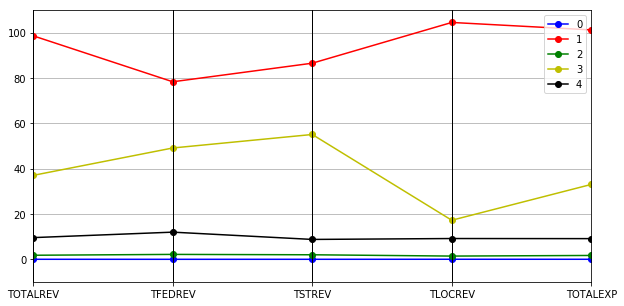

In [7]:
from itertools import cycle, islice
from pandas.plotting import parallel_coordinates

def parallel_plot(data):
    my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k', 'c']), None, len(data)))
    plt.figure(figsize=(10,5)).gca().axes.set_ylim([-10, 110])
    parallel_coordinates(data, 'prediction', color = my_colors, marker='o')
    
parallel_plot(centers_df)

**c)**
Create a new DataFrame by adding a `cluster` column to the original `edu_df` DataFrame. This is a convenient way of storing what cluster each sample belongs to.<br>
There are multiple ways of getting cluster ID's for each sample from our mode, read the <a href='http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html'>docs</a> for ideas. Get these labels and concatenate them as a new column onto `edu_df`.<br><br>
Print the DataFrame's shape and head.<br><br>


<i style='color:blue'>
<ul><li>Output Required:<ul>
        <li>(tuple) DataFrame's shape</li>
        <li>(DataFrame) The head of the DataFrame; should have cluster column</li>
</ul></li></ul>

In [8]:
preds = pd.Series(model.labels_)
prediction_df = pd.concat([X, preds.rename('cluster')], axis=1)
print(prediction_df.shape)
prediction_df.head()

(14325, 6)


,TOTALREV,TFEDREV,TSTREV,TLOCREV,TOTALEXP,cluster
0,0.119653,0.165508,0.259610,-0.014237,0.100770,0
1,1.045707,0.899419,1.008906,1.020939,0.864655,2
2,-0.134920,-0.064868,-0.137507,-0.133383,-0.127162,0
3,-0.077112,-0.009993,-0.051649,-0.103082,-0.059493,0
4,-0.054430,-0.005210,-0.002870,-0.101340,-0.053268,0


In [11]:
preds = pd.Series(model.labels_)
X['cluster'] = preds.rename('cluster')
print(prediction_df.shape)
prediction_df.head()

(14325, 6)


,TOTALREV,TFEDREV,TSTREV,TLOCREV,TOTALEXP,cluster
0,0.119653,0.165508,0.259610,-0.014237,0.100770,0
1,1.045707,0.899419,1.008906,1.020939,0.864655,2
2,-0.134920,-0.064868,-0.137507,-0.133383,-0.127162,0
3,-0.077112,-0.009993,-0.051649,-0.103082,-0.059493,0
4,-0.054430,-0.005210,-0.002870,-0.101340,-0.053268,0


**d)**
Print the size of each cluster (number of samples classified as that cluster) using the DataFrame created in **c**


<i style='color:blue'>
<ul><li>Output Required:<ul>
        <li>(ints) A cluster ID and cluster size per cluster</li>
</ul></li></ul>

In [9]:
print(prediction_df['cluster'].value_counts())

0    13993
2      314
4       16
3        1
1        1
Name: cluster, dtype: int64


### 1.5 Experiments (Open Ended)
Return to **1.3** and try different values for k (n_clusters). Observe how your choice in k affects your results in **1.4**. Once you've tried a few different values, pick the one that you think is "best" and leave that as your argument when you submit this assignment. In this question, write a short paragraph explaining your observations and why you chose the k you did. Use these questions to guide your explanation. 


<i style='color:blue'>
<ul><li>Output: Paragraph that answers these questions:<ul>
        <li>How did different values of k affect cluster sizes?</li>        
        <li>What k worked best?</li>
        <li>What does best really mean here, though?</li>
</ul></li></ul>

--- respond here ---

## Part 2: Regression (Education Finance Data and SAIPE Data)

We will perform linear regression to use our financial data to predict poverty rates

### 2.1 Merge Datasets
We'll be using the `Poverty Percent, All Ages` column from `saipe_df` as our label.<br>
In order to associate these labels with the correct counties, we must merge our two DataFrames using the county code.<br><br>

Use `edu_df`'s `CONUM` column and `saipe_df`'s `County FIPS Code` column to merge the DataFrames.<br><br> Your end goal is to produce a DataFrame with the columns:<br> `CONUM`, `TOTALREV`, `TFEDREV`, `TSTREV`, `TLOCREV`, `TOTALEXP`, `Poverty Percent, All Ages`<br>
It's important to inspect the head of the merged DataFrame before dropping the columns not listed above. This way, you can reassure yourself you merged the DataFrames properly.<br><br>

<i style='color:blue'>
<ul><li>Output Required:<ul>
        <li>tuple     -- DataFrame's shape</li>
        <li>DataFrame -- The head of the DataFrame (either with all the columns or just the ones listed above)</li>
</ul></li></ul>

In [10]:
saipe_df_m = saipe_df.copy()
saipe_df_m['CONUM'] = saipe_df_m['County FIPS Code']
m = edu_df.merge( saipe_df_m, on ='CONUM', how ='inner')
print('Merge dataframe shape is',m.shape)
m.head(10)

Merge dataframe shape is (4722, 11)


,NAME,CONUM,TOTALREV,TFEDREV,TSTREV,TLOCREV,TOTALEXP,State FIPS Code,County FIPS Code,Name,"Poverty Percent, All Ages"
0,MONTGOMERY COUNTY SCHOOL DISTRICT,1101,301121,42712,169038,89371,296474,1,1101,Montgomery County,18.8
1,PIKE ROAD SCHOOL DISTRICT,1101,9473,326,5276,3871,8943,1,1101,Montgomery County,18.8
2,DECATUR CITY SCHOOL DISTRICT,1103,99476,9576,45791,44109,109323,1,1103,Morgan County,15.8
3,MORGAN COUNTY SCHOOL DISTRICT,1103,78919,6537,41600,30782,81220,1,1103,Morgan County,15.8
4,HARTSELLE CITY SCHOOL DISTRICT,1103,30401,1588,17791,11022,29601,1,1103,Morgan County,15.8
5,PERRY COUNTY SCHOOL DISTRICT,1105,16271,3616,10175,2480,15450,1,1105,Perry County,35
6,PICKENS COUNTY SCHOOL DISTRICT,1107,26826,3541,17386,5899,27921,1,1107,Pickens County,25.8
7,PIKE COUNTY SCHOOL DISTRICT,1109,23840,3437,13858,6545,23530,1,1109,Pike County,25.1
8,TROY CITY SCHOOL DISTRICT,1109,20582,2097,10239,8246,19199,1,1109,Pike County,25.1
9,RANDOLPH COUNTY SCHOOL DISTRICT,1111,21531,2475,13280,5776,23702,1,1111,Randolph County,21.8


In [10]:
edu_df_trunc = edu_df[(edu_df['CONUM'].isin(saipe_df['County FIPS Code']))]
merged_df = pd.merge(edu_df_trunc, saipe_df, left_on='CONUM', right_on='County FIPS Code')
print(merged_df.shape)
merged_df.head()

(4722, 11)


,NAME,CONUM,TOTALREV,TFEDREV,TSTREV,TLOCREV,TOTALEXP,State FIPS Code,County FIPS Code,Name,"Poverty Percent, All Ages"
0,MONTGOMERY COUNTY SCHOOL DISTRICT,1101,301121,42712,169038,89371,296474,1,1101,Montgomery County,18.8
1,PIKE ROAD SCHOOL DISTRICT,1101,9473,326,5276,3871,8943,1,1101,Montgomery County,18.8
2,DECATUR CITY SCHOOL DISTRICT,1103,99476,9576,45791,44109,109323,1,1103,Morgan County,15.8
3,MORGAN COUNTY SCHOOL DISTRICT,1103,78919,6537,41600,30782,81220,1,1103,Morgan County,15.8
4,HARTSELLE CITY SCHOOL DISTRICT,1103,30401,1588,17791,11022,29601,1,1103,Morgan County,15.8


### 2.2 Train and test split
Shuffle your data and then partition it into an 80%/20% train/test split.<br>
Then, split up your train and test into a features DataFrame (X_train/X_test) and a labels DataFrame (y_train/y_test)<br>
X_train and X_test should have these coluns: `TOTALREV`, `TFEDREV`, `TSTREV`, `TLOCREV`, `TOTALEXP`<br>
y_train and y_test should have this column: `Poverty Percent, All Ages`<br>
<br><br> 


<i style='color:blue'>
<ul><li>Output Required:<ul>
        <li>tuple -- X_train DataFrame shape</li>
        <li>tuple -- y_train DataFrame shape</li>
        <li>tuple -- X_test DataFrame shape</li>    
        <li>tuple -- y_test DataFrame shape</li>
</ul></li></ul>

In [11]:
from sklearn.utils import shuffle

shuffled = shuffle(merged_df, random_state=123)
split = int(len(shuffled) * 0.8)
train = shuffled.iloc[:split]
test = shuffled.iloc[split:]
X_train = train[['TOTALREV', 'TFEDREV', 'TSTREV', 'TLOCREV', 'TOTALEXP']]
X_test = test[['TOTALREV', 'TFEDREV', 'TSTREV', 'TLOCREV', 'TOTALEXP']]
y_train = train['Poverty Percent, All Ages']
y_test = test['Poverty Percent, All Ages']

print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)
X_train.head()

X_train: (3777, 5)
y_train: (3777,)
X_test: (945, 5)
y_test: (945,)


,TOTALREV,TFEDREV,TSTREV,TLOCREV,TOTALEXP
2897,8445,166,3664,4615,22385
1503,4350,244,2782,1324,3970
2763,3523,2,289,3232,3182
4335,26638,1352,7929,17357,25367
2922,20423,545,13185,6693,14100


### 2.3 Fit a regressor
**a)**
Create a <a href="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html">linear regression model</a> and fit it to your training dataset.<br>

<i style='color:blue'>
    <ul>
        <li>No output necessary</li>
    </ul>
</i>

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import StandardScaler

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)


model = LinearRegression()

model.fit(X_train, y_train)
y_test_preds = model.predict(X_test)
RMSE = sqrt(mean_squared_error(y_true = y_test, y_pred = y_test_preds))

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. Thi

**b)**
Use your model to predict on your test set. Report the RMSE.

<i style='color:blue'>
<ul><li>Output: Paragraph that answers these questions:<ul>
    <li>float -- RMSE</li>
</ul></li></ul>

In [13]:
RMSE

5.7527887425264295